# Hypothesis 4: Mediation by Epistemic Trust
## Epistemic Trust Mediates SDT → AI Acceptance

**Hypothesis**: Epistemic Trust (ET_mean) will mediate the relationship between TENS_Life_mean and UTAUT_AI_mean.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from data_processing import load_and_prepare_data
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
combined_data = pd.read_csv('data/processed/combined_data.csv')

In [3]:
h4_data = combined_data[['TENS_Life_mean', 'UTAUT_AI_mean', 'ET_mean', 
                          'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']].dropna()

if h4_data['gender'].dtype == 'object':
    h4_data['gender'] = pd.Categorical(h4_data['gender']).codes

h4_data['TENS_Life_centered'] = h4_data['TENS_Life_mean'] - h4_data['TENS_Life_mean'].mean()

In [4]:
# Path a: TENS_Life → ET_mean
X_a = h4_data[['TENS_Life_centered', 'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']]
X_a = sm.add_constant(X_a)
y_a = h4_data['ET_mean']

model_a = sm.OLS(y_a, X_a).fit()
path_a = model_a.params['TENS_Life_centered']
print(f"Path a (TENS → ET): β = {path_a:.3f}, p = {model_a.pvalues['TENS_Life_centered']:.4f}")

Path a (TENS → ET): β = -0.005, p = 0.7666


In [5]:
# Path b: ET_mean → UTAUT_AI_mean
X_b = h4_data[['TENS_Life_centered', 'ET_mean', 'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']]
X_b = sm.add_constant(X_b)
y_b = h4_data['UTAUT_AI_mean']

model_b = sm.OLS(y_b, X_b).fit()
path_b = model_b.params['ET_mean']
path_c_prime = model_b.params['TENS_Life_centered']
print(f"Path b (ET → UTAUT_AI): β = {path_b:.3f}, p = {model_b.pvalues['ET_mean']:.4f}")
print(f"Path c' (Direct): β = {path_c_prime:.3f}, p = {model_b.pvalues['TENS_Life_centered']:.4f}")

Path b (ET → UTAUT_AI): β = 0.098, p = 0.0000
Path c' (Direct): β = -0.036, p = 0.0003


In [6]:
# Total effect
X_c = h4_data[['TENS_Life_centered', 'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']]
X_c = sm.add_constant(X_c)
y_c = h4_data['UTAUT_AI_mean']

model_c = sm.OLS(y_c, X_c).fit()
path_c = model_c.params['TENS_Life_centered']
indirect_effect = path_a * path_b

print(f"Total effect (c): β = {path_c:.3f}")
print(f"Indirect effect (a × b): {indirect_effect:.3f}")
print(f"Direct effect (c'): {path_c_prime:.3f}")

Total effect (c): β = -0.036
Indirect effect (a × b): -0.000
Direct effect (c'): -0.036


In [7]:
# Bootstrap CI
def bootstrap_indirect_effect(data, n_bootstrap=5000):
    indirect_effects = []
    n = len(data)
    print(f"Running bootstrap with {n_bootstrap} iterations...")
    for i in range(n_bootstrap):
        if (i + 1) % 1000 == 0:
            print(f"  Completed {i + 1}/{n_bootstrap}...")
        sample = data.sample(n=n, replace=True)
        X_a_s = sm.add_constant(sample[['TENS_Life_centered', 'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']])
        y_a_s = sample['ET_mean']
        a = sm.OLS(y_a_s, X_a_s).fit().params['TENS_Life_centered']
        X_b_s = sm.add_constant(sample[['TENS_Life_centered', 'ET_mean', 'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']])
        y_b_s = sample['UTAUT_AI_mean']
        b = sm.OLS(y_b_s, X_b_s).fit().params['ET_mean']
        indirect_effects.append(a * b)
    return np.array(indirect_effects)

indirect_effects_boot = bootstrap_indirect_effect(h4_data, n_bootstrap=5000)
ci_lower = np.percentile(indirect_effects_boot, 2.5)
ci_upper = np.percentile(indirect_effects_boot, 97.5)
print(f"\nBootstrap 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print(f"{'✓ H4 SUPPORTED' if ci_lower > 0 or ci_upper < 0 else '✗ H4 NOT SUPPORTED'}")

Running bootstrap with 5000 iterations...
  Completed 1000/5000...
  Completed 2000/5000...
  Completed 3000/5000...
  Completed 4000/5000...
  Completed 5000/5000...

Bootstrap 95% CI: [-0.005, 0.003]
✗ H4 NOT SUPPORTED


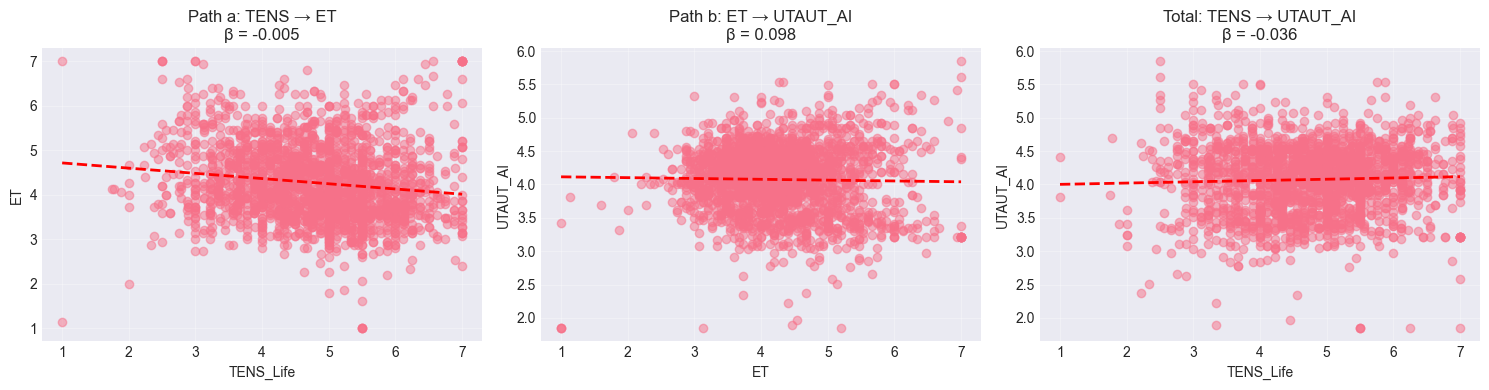

In [8]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, x, y, title, beta in zip(axes, 
    [h4_data['TENS_Life_mean'], h4_data['ET_mean'], h4_data['TENS_Life_mean']],
    [h4_data['ET_mean'], h4_data['UTAUT_AI_mean'], h4_data['UTAUT_AI_mean']],
    ['Path a: TENS → ET', 'Path b: ET → UTAUT_AI', 'Total: TENS → UTAUT_AI'],
    [path_a, path_b, path_c]):
    ax.scatter(x, y, alpha=0.5)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    sorted_x = x.sort_values()
    ax.plot(sorted_x, p(sorted_x), color='red', linestyle='--', linewidth=2)
    ax.set_title(f'{title}\nβ = {beta:.3f}')
    ax.grid(True, alpha=0.3)

axes[0].set_xlabel('TENS_Life')
axes[0].set_ylabel('ET')
axes[1].set_xlabel('ET')
axes[1].set_ylabel('UTAUT_AI')
axes[2].set_xlabel('TENS_Life')
axes[2].set_ylabel('UTAUT_AI')
plt.tight_layout()
plt.show()